In [1]:
# Imports
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import time

from scipy.io import wavfile
from sklearn.preprocessing import OneHotEncoder

In [2]:
# Read WAV FILE
samp_rate, data = wavfile.read("Song0_KieLoKaz_-_02_-_Trip_to_Ganymed_Kielokaz_ID_363.wav")

In [104]:
mono_channel = data[:,0]

x_train = mono_channel.copy()

layers = 10

n_window = int(2**layers)
n_data = 10000*n_window

# Cut down the data
x_train = x_train[:n_data]

# One hot encode output channels
enc = OneHotEncoder(categories='auto')
enc.fit(x_train.reshape(-1,1))

x_train_onehot = enc.transform(x_train.reshape(-1,1)).toarray()

# Get channels
n_channels = x_train_onehot.shape[1]
x_train_onehot = x_train_onehot.reshape(-1, n_window, n_channels)

In [105]:
def add_wavenet_layer(input_layer, dilation):
    
    # Layer
    conv_sig = tf.keras.layers.Conv1D(filters=255, kernel_size=2, strides=1, padding="causal",
                                          dilation_rate=dilation, activation='sigmoid')(input_layer)
    conv_tanh = tf.keras.layers.Conv1D(filters=255, kernel_size=2, strides=1, padding="causal",
                                          dilation_rate=dilation, activation='tanh')(input_layer)
    resulting_layer = tf.keras.layers.Multiply()([conv_sig, conv_tanh])

    return(resulting_layer)

In [106]:
model_input = tf.keras.layers.Input(shape=(n_window,n_channels))

# Add a single WAVENET layer
out_layer = add_wavenet_layer(model_input, 1)

#Add another 9 (10 are used in the paper - 1024 input span)
for i in range(layers-1):
     out_layer = add_wavenet_layer(out_layer, 2**(i+1))

# Add final output softmax
output_pred = tf.keras.layers.Conv1D(filters=n_channels, kernel_size=1, padding='same', activation='sigmoid')(out_layer)

In [107]:
test_model = tf.keras.Model(model_input, output_pred)

In [108]:
test_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 1024, 247)]  0                                            
__________________________________________________________________________________________________
conv1d_108 (Conv1D)             (None, 1024, 255)    126225      input_9[0][0]                    
__________________________________________________________________________________________________
conv1d_109 (Conv1D)             (None, 1024, 255)    126225      input_9[0][0]                    
__________________________________________________________________________________________________
multiply_50 (Multiply)          (None, 1024, 255)    0           conv1d_108[0][0]                 
                                                                 conv1d_109[0][0]           

In [ ]:
# Compile and fit
test_model.compile(optimizer='adam', loss='categorical_crossentropy')

test_model.fit(x_train_onehot, x_train_onehot, epochs=1)

1 layer - 1024 window - 304,198 weights = 16s \
2 layer - 1024 window - 564,808 weights = 22s \
3 layer - 1024 window - 825,418 weights = 31s \
4 layer - 1024 window - 1,086,028 weights = 40s \
5 layer - 1024 window - 1,346,638 weights = 49s

### 10000 datapoints

5 layer - 32 window - 1,079,954 weights = 8s 

6 layer - 64 window - 1,375,016 weights = 14s 

7 layer - 128 window - 1,710,910 weights - 25s 

8 layer - 256 window - 2,099,120 weights - 49s 

9 layer - 512 window - 2,389,078 weights - 93s


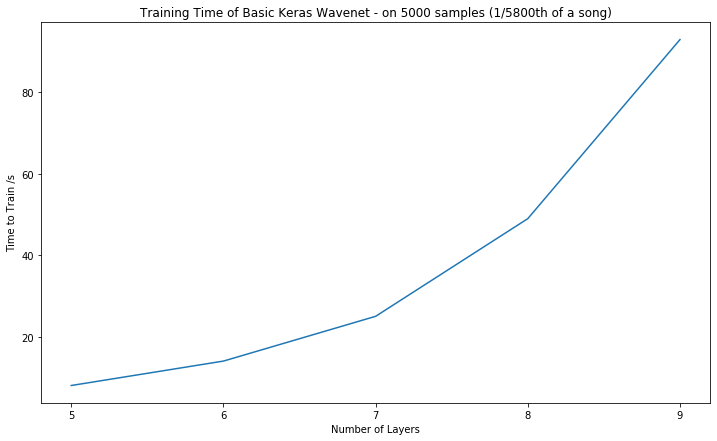

In [103]:
plt.figure(figsize=(12,7))

plt.plot(["5", "6", "7", "8", "9"],[8, 14, 25, 49, 93])
plt.xlabel('Number of Layers')
plt.ylabel('Time to Train /s')
plt.title("Training Time of Basic Keras Wavenet - on 5000 samples (1/5800th of a song)")

plt.show()